<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/SAINT_(3_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# SAINT Model for Agricultural Production Classification - 3 Labels (Low, Medium, High)
# Step-by-step implementation without main function

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("All libraries imported successfully!")
print("Random seeds set for reproducibility")


All libraries imported successfully!
Random seeds set for reproducibility


In [2]:
# =============================================================================
# STEP 1: Data Loading and Preprocessing Functions
# =============================================================================

def load_and_preprocess_data():
    """Load and preprocess the three CSV files"""

    print("Step 1: Loading and preprocessing data...")

    # Load datasets
    train_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/train.csv')
    validation_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/validation.csv')
    test_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/test.csv')

    print(f"Train dataset shape: {train_df.shape}")
    print(f"Validation dataset shape: {validation_df.shape}")
    print(f"Test dataset shape: {test_df.shape}")

    # Display basic info about datasets
    print("\nTrain dataset columns:")
    print(train_df.columns.tolist())
    print(f"\nProduction column stats (Train):")
    print(train_df['Production (M.Ton)'].describe())

    # Combine all datasets to get global quantiles for consistent labeling
    all_data = pd.concat([train_df, validation_df, test_df], ignore_index=True)

    # Create quantile-based labels for production (3 labels)
    production_quantiles = all_data['Production (M.Ton)'].quantile([0.33, 0.67])
    print(f"\nProduction quantiles for labeling:")
    print(f"33rd percentile (Low-Medium threshold): {production_quantiles[0.33]:.2f}")
    print(f"67th percentile (Medium-High threshold): {production_quantiles[0.67]:.2f}")

    def create_production_labels(production_values):
        labels = []
        for value in production_values:
            if value <= production_quantiles[0.33]:
                labels.append(0)  # Low
            elif value <= production_quantiles[0.67]:
                labels.append(1)  # Medium
            else:
                labels.append(2)  # High
        return labels

    # Apply labels to all datasets
    train_df['Production_Label'] = create_production_labels(train_df['Production (M.Ton)'])
    validation_df['Production_Label'] = create_production_labels(validation_df['Production (M.Ton)'])
    test_df['Production_Label'] = create_production_labels(test_df['Production (M.Ton)'])

    # Remove the original production column from features
    feature_columns = [col for col in train_df.columns if col not in ['Production (M.Ton)', 'Production_Label']]

    X_train = train_df[feature_columns]
    y_train = train_df['Production_Label']

    X_val = validation_df[feature_columns]
    y_val = validation_df['Production_Label']

    X_test = test_df[feature_columns]
    y_test = test_df['Production_Label']

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    print("Data preprocessing completed!")
    print(f"Number of features: {X_train_scaled.shape[1]}")
    print(f"Label distribution in training set:")
    print(pd.Series(y_train).value_counts().sort_index())
    print(f"Label distribution in validation set:")
    print(pd.Series(y_val).value_counts().sort_index())
    print(f"Label distribution in test set:")
    print(pd.Series(y_test).value_counts().sort_index())

    return X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test, scaler


In [3]:


# =============================================================================
# STEP 2: Dataset Class Definition
# =============================================================================

class ProductionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y.values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

print("ProductionDataset class defined successfully!")


ProductionDataset class defined successfully!


In [4]:

# =============================================================================
# STEP 3: SAINT Model Architecture
# =============================================================================

class SAINT(nn.Module):
    def __init__(self, input_dim, num_classes=3, d_model=128, nhead=8, num_layers=4, dropout=0.1):
        super(SAINT, self).__init__()

        self.input_dim = input_dim
        self.d_model = d_model
        self.num_classes = num_classes

        # Input embedding layer
        self.input_embedding = nn.Linear(input_dim, d_model)

        # Positional encoding (simplified)
        self.pos_encoding = nn.Parameter(torch.randn(1, 1, d_model))

        # Self-attention transformer layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Inter-sample attention mechanism
        self.inter_sample_attention = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=nhead,
            dropout=dropout,
            batch_first=True
        )

        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size = x.size(0)

        # Input embedding
        x = self.input_embedding(x)  # (batch_size, d_model)
        x = x.unsqueeze(1)  # (batch_size, 1, d_model)

        # Add positional encoding
        x = x + self.pos_encoding

        # Self-attention
        x = self.transformer(x)  # (batch_size, 1, d_model)

        # Inter-sample attention (simplified version)
        attended_x, _ = self.inter_sample_attention(x, x, x)

        # Combine original and attended features
        x = x + attended_x
        x = self.dropout(x)

        # Global average pooling
        x = x.squeeze(1)  # (batch_size, d_model)

        # Classification
        output = self.classifier(x)

        return output

print("SAINT model architecture defined successfully!")


SAINT model architecture defined successfully!


In [5]:

# =============================================================================
# STEP 4: Training Function
# =============================================================================

def train_model(model, train_loader, val_loader, num_epochs=50, device='cpu'):
    """Train the SAINT model"""

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_acc = 0.0
    best_model_state = None

    print(f"Training SAINT model for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()

        train_acc = 100 * train_correct / train_total
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()

        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)

        scheduler.step(val_loss / len(val_loader))

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.2f}%')

    # Load best model
    model.load_state_dict(best_model_state)

    print(f"Training completed! Best validation accuracy: {best_val_acc:.2f}%")

    return model, train_losses, val_losses, train_accuracies, val_accuracies

print("Training function defined successfully!")


Training function defined successfully!


In [6]:

# =============================================================================
# STEP 5: Evaluation Functions
# =============================================================================

def evaluate_model(model, test_loader, device='cpu'):
    """Evaluate model and return predictions"""
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    return np.array(all_predictions), np.array(all_labels)

def calculate_metrics(y_true, y_pred):
    """Calculate comprehensive classification metrics"""

    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Individual class metrics
    precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)

    return {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class
    }

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix", labels=None):
    """Plot confusion matrix"""
    if labels is None:
        labels = ['Low', 'Medium', 'High']

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='red')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracies
    ax2.plot(train_accuracies, label='Training Accuracy', color='blue')
    ax2.plot(val_accuracies, label='Validation Accuracy', color='red')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def save_model(model, scaler, filepath_prefix="saint_model_3labels"):
    """Save the trained model and scaler"""
    torch.save(model.state_dict(), f"{filepath_prefix}.pth")
    import joblib
    joblib.dump(scaler, f"{filepath_prefix}_scaler.pkl")
    print(f"Model saved as {filepath_prefix}.pth")
    print(f"Scaler saved as {filepath_prefix}_scaler.pkl")

print("All evaluation functions defined successfully!")


All evaluation functions defined successfully!


In [7]:

# =============================================================================
# STEP 6: Execute Data Loading and Preprocessing
# =============================================================================

print("\n" + "="*70)
print("EXECUTING STEP 6: DATA LOADING AND PREPROCESSING")
print("="*70)

# Load and preprocess data
X_train, y_train, X_val, y_val, X_test, y_test, scaler = load_and_preprocess_data()

print(f"\nData shapes after preprocessing:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")



EXECUTING STEP 6: DATA LOADING AND PREPROCESSING
Step 1: Loading and preprocessing data...
Train dataset shape: (3942, 84)
Validation dataset shape: (845, 84)
Test dataset shape: (845, 84)

Train dataset columns:
['Production (M.Ton)', 'Area (Acres)', 'Temperature at 2 Meters Range (C)', 'Year', 'soil_temperature_0_to_7cm(C)', 'Root Zone Soil Wetness (surface to 100 cm below)', 'Surface Soil Wetness (surface to 5 cm below)', 'soil_moisture_0_to_7cm(mÂ³/mÂ³)', 'soil_moiture_7_to_28cm(mÂ³/mÂ³)', 'total_rain_mm', 'relative_humidity_2m(%)', 'Precipitation Corrected (mm)', 'Crop_Beans', 'Crop_Cabbage', 'Crop_Cauliflower', 'Crop_Garlic', 'Crop_Laushak', 'Crop_Onion', 'Crop_Radish', 'Crop_Tomato', 'District_Bagerhat', 'District_Bandarban', 'District_Barguna', 'District_Barishal', 'District_Bhola', 'District_Bogura', 'District_Brahmanbaria', 'District_Chandpur', 'District_Chapai Nawabganj', 'District_Chattogram', 'District_Chuadanga', 'District_Comilla', "District_Cox's Bazar", 'District_Dhak

In [8]:

# =============================================================================
# STEP 7: Create Datasets and DataLoaders
# =============================================================================

print("\n" + "="*70)
print("EXECUTING STEP 7: CREATING DATASETS AND DATALOADERS")
print("="*70)

# Create datasets and dataloaders
train_dataset = ProductionDataset(X_train, y_train)
val_dataset = ProductionDataset(X_val, y_val)
test_dataset = ProductionDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Datasets created successfully!")
print(f"Batch size: {batch_size}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")



EXECUTING STEP 7: CREATING DATASETS AND DATALOADERS
Datasets created successfully!
Batch size: 32
Training batches: 124
Validation batches: 27
Test batches: 27


In [9]:

# =============================================================================
# STEP 8: Initialize Model and Check Device
# =============================================================================

print("\n" + "="*70)
print("EXECUTING STEP 8: MODEL INITIALIZATION")
print("="*70)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model
input_dim = X_train.shape[1]
model = SAINT(input_dim=input_dim, num_classes=3, d_model=128, nhead=8, num_layers=4, dropout=0.1)
model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model initialized successfully!")
print(f"Input dimension: {input_dim}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")



EXECUTING STEP 8: MODEL INITIALIZATION
Using device: cpu
Model initialized successfully!
Input dimension: 83
Total parameters: 878,723
Trainable parameters: 878,723


In [10]:

# =============================================================================
# STEP 9: Train the Model
# =============================================================================

print("\n" + "="*70)
print("EXECUTING STEP 9: MODEL TRAINING")
print("="*70)

# Train model
num_epochs = 100  # You can adjust this
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, num_epochs=num_epochs, device=device
)



EXECUTING STEP 9: MODEL TRAINING
Training SAINT model for 100 epochs...
Epoch [10/100], Train Loss: 0.3885, Train Acc: 85.59%, Val Loss: 0.4171, Val Acc: 84.02%
Epoch [20/100], Train Loss: 0.3290, Train Acc: 87.47%, Val Loss: 0.3650, Val Acc: 83.31%
Epoch [30/100], Train Loss: 0.2541, Train Acc: 90.74%, Val Loss: 0.3176, Val Acc: 88.28%
Epoch [40/100], Train Loss: 0.2576, Train Acc: 90.28%, Val Loss: 0.3256, Val Acc: 87.81%
Epoch [50/100], Train Loss: 0.1463, Train Acc: 94.70%, Val Loss: 0.2933, Val Acc: 91.72%
Epoch [60/100], Train Loss: 0.1194, Train Acc: 95.81%, Val Loss: 0.3052, Val Acc: 92.19%
Epoch [70/100], Train Loss: 0.1096, Train Acc: 95.94%, Val Loss: 0.3024, Val Acc: 91.95%
Epoch [80/100], Train Loss: 0.0991, Train Acc: 96.25%, Val Loss: 0.3116, Val Acc: 92.19%
Epoch [90/100], Train Loss: 0.1054, Train Acc: 96.27%, Val Loss: 0.3121, Val Acc: 92.07%
Epoch [100/100], Train Loss: 0.0967, Train Acc: 96.65%, Val Loss: 0.3128, Val Acc: 91.95%
Training completed! Best validation 


EXECUTING STEP 10: PLOTTING TRAINING HISTORY


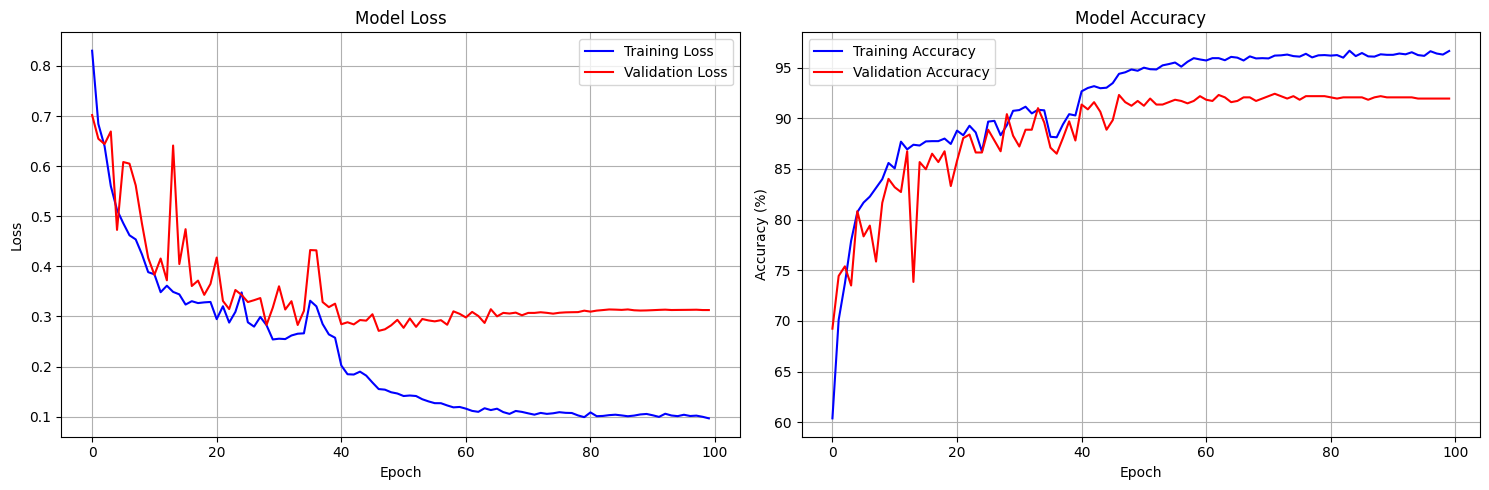

In [11]:

# =============================================================================
# STEP 10: Plot Training History
# =============================================================================

print("\n" + "="*70)
print("EXECUTING STEP 10: PLOTTING TRAINING HISTORY")
print("="*70)

plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)



EXECUTING STEP 11: VALIDATION SET EVALUATION
Validation Results:
Accuracy: 0.9195
Precision (Macro): 0.9197
Recall (Macro): 0.9207
F1-Score (Macro): 0.9200
F1-Score (Weighted): 0.9193


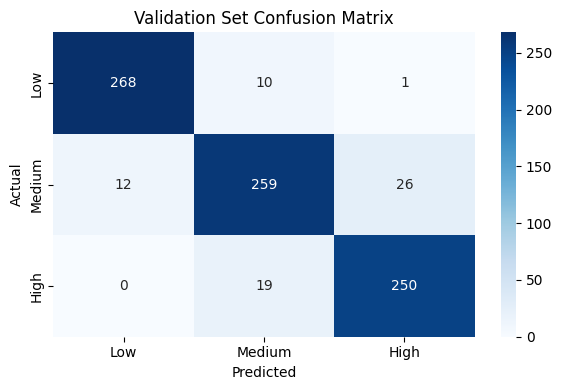

In [12]:

# =============================================================================
# STEP 11: Validation Set Evaluation
# =============================================================================

print("\n" + "="*70)
print("EXECUTING STEP 11: VALIDATION SET EVALUATION")
print("="*70)

val_predictions, val_true = evaluate_model(model, val_loader, device)
val_metrics = calculate_metrics(val_true, val_predictions)

print(f"Validation Results:")
print(f"Accuracy: {val_metrics['accuracy']:.4f}")
print(f"Precision (Macro): {val_metrics['precision_macro']:.4f}")
print(f"Recall (Macro): {val_metrics['recall_macro']:.4f}")
print(f"F1-Score (Macro): {val_metrics['f1_macro']:.4f}")
print(f"F1-Score (Weighted): {val_metrics['f1_weighted']:.4f}")

# Plot validation confusion matrix
plot_confusion_matrix(val_true, val_predictions, "Validation Set Confusion Matrix")



EXECUTING STEP 12: TEST SET EVALUATION
Test Results:
Accuracy: 0.9361
Precision (Macro): 0.9362
Recall (Macro): 0.9360
F1-Score (Macro): 0.9360
F1-Score (Weighted): 0.9362


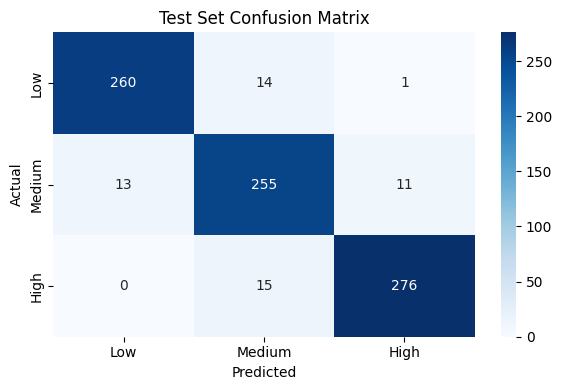

In [13]:

# =============================================================================
# STEP 12: Test Set Evaluation
# =============================================================================

print("\n" + "="*70)
print("EXECUTING STEP 12: TEST SET EVALUATION")
print("="*70)

test_predictions, test_true = evaluate_model(model, test_loader, device)
test_metrics = calculate_metrics(test_true, test_predictions)

print(f"Test Results:")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision (Macro): {test_metrics['precision_macro']:.4f}")
print(f"Recall (Macro): {test_metrics['recall_macro']:.4f}")
print(f"F1-Score (Macro): {test_metrics['f1_macro']:.4f}")
print(f"F1-Score (Weighted): {test_metrics['f1_weighted']:.4f}")

# Plot test confusion matrix
plot_confusion_matrix(test_true, test_predictions, "Test Set Confusion Matrix")


In [14]:

# =============================================================================
# STEP 13: Detailed Results Analysis
# =============================================================================

print("\n" + "="*70)
print("EXECUTING STEP 13: DETAILED RESULTS ANALYSIS")
print("="*70)

# Detailed classification report
labels = ['Low', 'Medium', 'High']
print("Detailed Classification Report (Test Set):")
print(classification_report(test_true, test_predictions, target_names=labels))

# Per-class metrics
print("\nPer-class Metrics (Test Set):")
for i, label in enumerate(labels):
    if i < len(test_metrics['precision_per_class']):
        print(f"{label}: Precision={test_metrics['precision_per_class'][i]:.4f}, "
              f"Recall={test_metrics['recall_per_class'][i]:.4f}, "
              f"F1={test_metrics['f1_per_class'][i]:.4f}")



EXECUTING STEP 13: DETAILED RESULTS ANALYSIS
Detailed Classification Report (Test Set):
              precision    recall  f1-score   support

         Low       0.95      0.95      0.95       275
      Medium       0.90      0.91      0.91       279
        High       0.96      0.95      0.95       291

    accuracy                           0.94       845
   macro avg       0.94      0.94      0.94       845
weighted avg       0.94      0.94      0.94       845


Per-class Metrics (Test Set):
Low: Precision=0.9524, Recall=0.9455, F1=0.9489
Medium: Precision=0.8979, Recall=0.9140, F1=0.9059
High: Precision=0.9583, Recall=0.9485, F1=0.9534


In [15]:

# =============================================================================
# STEP 14: Final Summary and Model Saving
# =============================================================================

print("\n" + "="*70)
print("EXECUTING STEP 14: FINAL SUMMARY")
print("="*70)

print("SAINT Model Training for Agricultural Production Classification (3 Labels) - COMPLETED!")
print(f"Final Test Macro F1-Score: {test_metrics['f1_macro']:.4f}")
print(f"Final Test Accuracy: {test_metrics['accuracy']:.4f}")



print("\n" + "="*70)
print("ALL STEPS COMPLETED SUCCESSFULLY!")
print("="*70)


EXECUTING STEP 14: FINAL SUMMARY
SAINT Model Training for Agricultural Production Classification (3 Labels) - COMPLETED!
Final Test Macro F1-Score: 0.9360
Final Test Accuracy: 0.9361

ALL STEPS COMPLETED SUCCESSFULLY!
